## Assignment 05

#### Submitted By:
1. Dhruvan Ganesh
2. Sheikh Mastura Farzana

In [1]:
%load_ext tensorboard

### Environment Information
---

In [2]:
import torch.cuda
from pytorch_lightning import seed_everything
from torch import device

device = device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))

seed = 42
seed_everything(seed)
print("Set Random Seed:", seed)

Device: cuda:0
Device Name: GeForce GTX 1660 Ti
Set Random Seed: 42


### Task 1.1 Gather a dataset for humanoid robot
---

Under the `scripts\` directory, the following can be found

- download-videos.sh :- Download the provided videos
- extract-images.sh :- Extract 1 frame every second; manually classify into `robot` and `no_robot`, for training
- crop.sh :- Crop images into squares since otherwise, we cannot visualize the sides that are cropped out by the
preprocessing step.

We removed images that fit the below criteria:

- blurred images
- images with occluded robots
- duplicate images (if 2 frames are identical)
- images with only text

> **NOTE: Without cropping but with our filtering criteria, our `/uncropped` dataset (1366 robot, 566 no-robot)
> gave us train/valid accuracies of 99.99%/96.04% respectively.**

The `datasets\` folder contains the respective `cropped` and `uncropped` folders

### Task 1.2 Finetune DenseNet for Humanoid Robot Classification
---

In [3]:
import torch
from pytorch_lightning import LightningModule
from torch.utils.data import DataLoader

import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.models import densenet121 as PretrainedDenseNet


class DenseNetFinetune(LightningModule):
    def __init__(self, train_dataset_path, validation_dataset_path=None, batch_size=64):
        super(DenseNetFinetune, self).__init__()
        self.model = PretrainedDenseNet(pretrained=True)
        self.preprocess = transforms.Compose(
            [
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.undo_preprocess = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        self.train_dataset = datasets.ImageFolder(
            root=train_dataset_path, transform=self.preprocess
        )
        if validation_dataset_path is None:
            validation_set_length = int(len(self.train_dataset) * 0.2)
            self.train_dataset, self.valid_dataset = torch.utils.data.random_split(
                self.train_dataset,
                [
                    len(self.train_dataset) - validation_set_length,
                    validation_set_length,
                ],
            )
        else:
            self.valid_dataset = datasets.ImageFolder(
                root=validation_dataset_path, transform=self.preprocess
            )
        self.batch_size = batch_size
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        labels_hat = torch.argmax(y_hat, dim=1)
        train_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)
        tensorboard_logs = {"train_loss": loss.item(), "train_acc": train_acc}
        return {"loss": loss, "log": tensorboard_logs}

    def train_dataloader(self):
        loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )
        return loader

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        labels_hat = torch.argmax(y_hat, dim=1)
        val_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)
        return {"val_loss": self.loss(y_hat, y), "val_acc": torch.tensor(val_acc)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss, "val_acc": avg_acc}
        return {"val_loss": avg_loss, "val_acc": avg_acc, "log": tensorboard_logs}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
        return [optimizer], [scheduler]

    def val_dataloader(self):
        loader = DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )
        return loader

    @torch.no_grad()
    def get_all_val_preds(self, rdev=device):
        all_preds = torch.tensor([]).to(device)
        labels = torch.tensor([], dtype=torch.int64).to(device)
        for x, y in self.val_dataloader():
            x, y = x.to(device), y.to(device)
            y_hat = self(x)
            all_preds = torch.cat((all_preds, y_hat), dim=0)
            labels = torch.cat((labels, y), dim=0)
        pred_labels = all_preds.argmax(dim=1)
        return pred_labels.to(rdev), labels.to(rdev)

In [4]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6007 (pid 91615), started 0:14:15 ago. (Use '!kill 91615' to kill it.)

In [5]:
from pytorch_lightning import Trainer

lightning_model = DenseNetFinetune(
    train_dataset_path="./dataset/cropped", batch_size=32
)

trainer = Trainer(gpus=1,
                  num_nodes=1,
                  deterministic=True,
                  max_epochs=15)

trainer.fit(lightning_model)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                                          | Type             | Params
-------------------------------------------------------------------------------
0   | model                                         | DenseNet         | 7 M   
1   | model.features                                | Sequential       | 6 M   
2   | model.features.conv0                          | Conv2d           | 9 K   
3   | model.features.norm0                          | BatchNorm2d      | 128   
4   | model.features.relu0                          | ReLU             | 0     
5   | model.features.pool0                          | MaxPool2d        | 0     
6   | model.features.denseblock1                    | _DenseBlock      | 335 K 
7   | model.features.denseblock1.denselayer1        | _DenseLayer      | 45 K  
8   | model.features.denseblock1.denselayer1.norm1  | BatchNorm2d      | 128   
9   

/home/dhruvang/Applications/miniconda3/envs/cudavision/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


1

In [6]:
import numpy as np
from sklearn.metrics import classification_report

pred_labels, labels = lightning_model.get_all_val_preds(rdev="cpu")
pred_labels, labels = pred_labels.numpy(), labels.numpy()
print(classification_report(pred_labels, labels))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        82
           1       1.00      0.98      0.99       125

    accuracy                           0.99       207
   macro avg       0.99      0.99      0.99       207
weighted avg       0.99      0.99      0.99       207



### Metrics After Fit

| Datasets  | Train Accuracy | Test Accuracy |
|-----------|----------------|---------------|
| Uncropped | 99.99%         | 96.04%        |
| Cropped   | 99.99%         | 99.54%        |

### Inspection: Print Miss-Classified Image and Investigate
---

[183  86]


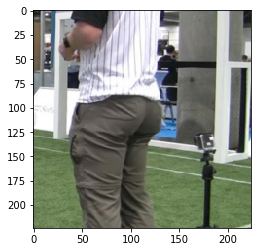

Correct Label: no_robot


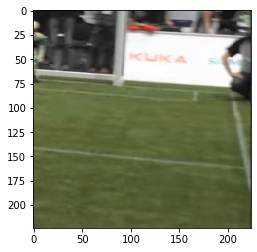

Correct Label: no_robot


In [7]:
import matplotlib.pyplot as plt

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.show()

val_idx = np.array(lightning_model.valid_dataset.indices)
incorrect_preds = np.nonzero((pred_labels != labels))
incorrect_idx = val_idx[incorrect_preds]
print(incorrect_idx)

for idx in incorrect_idx:
    img, label = lightning_model.valid_dataset.dataset[idx]
    img = lightning_model.undo_preprocess(img)
    show(img)
    print("Correct Label:", lightning_model.valid_dataset.dataset.classes[label])